In [1]:
import pyspeckit as ps
from astropy.io import fits
from bokeh.layouts import column

import os

from bokeh.palettes import Spectral4


import astropy.units as u
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools
from bokeh.models import Span, Label, Arrow, NormalHead
import numpy as np
output_notebook()
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

#f = fits.open('../Observation1/data/FixedAstrometryDATACUBE_FINAL.fits')

#c = ps.Cube(f[1])
cube1= SpectralCube.read('../../Observation1/data/FixedAstrometryDATACUBE_FINAL.fits',hdu=1)






##Emission Lines
class line(object):
    def __init__(self,name):
        self.name = name


#c = ps.Cube(cube=cube1)

Loading BokehJS ...

Param #0   AMPLITUDE0 =      1845.73 +/-         2.13851 
Param #1       SHIFT0 =      6564.04 +/-     0.000911468 
Param #2       WIDTH0 =      1.18668 +/-      0.00126031   Range:   [0,inf)
Param #3   AMPLITUDE1 =     -1741.77 +/-         2.08114 
Param #4       SHIFT1 =      6565.26 +/-      0.00211577 
Param #5       WIDTH1 =      3.09839 +/-      0.00179577   Range:   [0,inf)


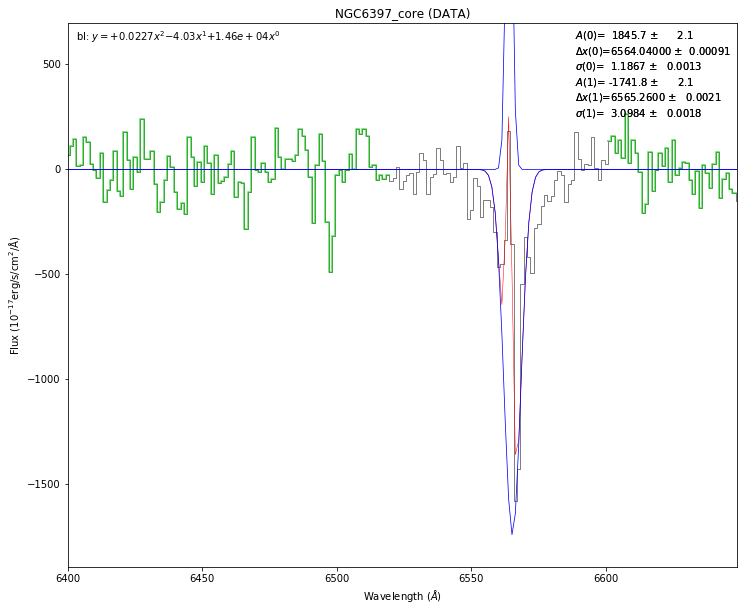

In [11]:
sourcename = 'U12'
region = 'fk5; circle(17:40:44.6207, -53:40:41.961, 0.200")'
backgroundreg = 'fk5; circle(17:40:44.4171, -53:40:39.027, 0.200")'


filename = '{}.fits'.format(sourcename)
filenamesky = '{}sky.fits'.format(sourcename)
diclines = {line("H"+'\u03D0'):4861,line('H'+u"\u03B1"):6563,line('He I'):5876,line('He I'):6678,line('He I'):7065,line('He I'):4912,line('He I'):5016,
           line("?"):5965}
plotlines = 'True'

#Spectrum
subcube = cube1.subcube_from_ds9region(region)  
spectrum = subcube.sum(axis=(1, 2)) 

#Sky
subcubesky = cube1.subcube_from_ds9region(backgroundreg)  
spectrumsky = subcubesky.sum(axis=(1, 2)) 

if os.path.isfile(filename):
    os.remove(filename)
spectrum.write(filename)



if os.path.isfile(filenamesky):
    os.remove(filenamesky)
spectrumsky.write(filenamesky)



###
#Substarct the sky
pyspec = ps.Spectrum(filename)
pyspecsky = ps.Spectrum(filenamesky)

skysubstractedpyspec = pyspec - pyspecsky

        
#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )

        


# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='pan', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)







##Second plot
# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)



#Plot 2
##Second plot
# create a new plot
p2 = figure(plot_width=900, plot_height=500, title=sourcename+'no sky',active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers

inds = np.argsort(skysubstractedpyspec.xarr)
xp2 = skysubstractedpyspec.xarr.value[inds]
yp2 = skysubstractedpyspec.data[inds]

p2.line(xp2,yp2)

x = np.array(xp2)
y = np.array(yp2)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 205, x_end = xloc, y_end= yloc+100
            )
    if plotlines == 'True':
        p2.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+200, text=name.name)
        p2.add_layout(my_label)


p2.add_tools(hover2)



inds = np.argsort(skysubstractedpyspec.xarr)


#Build gaussian


fig1 = plt.figure(sourcename,figsize=(12,10))
skysubstractedpyspec.plotter(fig1)

#skysubstractedpyspec.plotter()


skysubstractedpyspec.crop(6400., 6650, unit='angstrom') 


#skysubstractedpyspec.baseline(exclude=[4000,5000,6450,6746,6815,6884,7003,7126,7506,7674,8142,8231], order=5,subtract=False, highlight_fitregion=True)
skysubstractedpyspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=True, highlight_fitregion=True)



#skysubstractedpyspec.plotter(xmin=6100,xmax=7000)



#skysubstractedpyspec.plotter()

skysubstractedpyspec.specfit(guesses=[100.,6565.,1.,-100.,6560.,1.], 
             fittype='gaussian', show_components=True, annotate =True)

# Make some nice axis labels
skysubstractedpyspec.plotter.axis.set_xlabel(r'Wavelength $(\AA)$')
skysubstractedpyspec.plotter.axis.set_ylabel(r'Flux $(10^{-17} \mathrm{erg/s/cm^2/\AA})$')
skysubstractedpyspec.plotter.refresh()



skysubstractedpyspec.plotter.refresh()


#Info line
# print the fit results in table form
# This includes getting the equivalent width for each component using sp.specfit.EQW
print(skysubstractedpyspec.specfit.parinfo)
show(column(p,p2)) 